In [ ]:
!pip install deap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h1> Taking Iris dataset

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neural_network import MLPClassifier


RANDOM_STATE = 42
data = datasets.load_iris()
X = data['data']
y = data['target']
X_names = data['feature_names']
y_names = data['target_names']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=RANDOM_STATE)
DATA_SPLITTER = KFold(n_splits = 5, random_state=RANDOM_STATE, shuffle=True)

<h1> Initial results

In [ ]:
model_test: MLPClassifier = MLPClassifier(hidden_layer_sizes=(100,), random_state=RANDOM_STATE)
cv_scores = cross_val_score(model_test, X, y, cv=DATA_SPLITTER, n_jobs=-1, scoring="accuracy")
params_test = model_test.get_params()
score_test = cv_scores.mean()
print(params_test)
print(score_test)

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 30, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
0.9800000000000001


<h1> Changed crossover methode and real fitness function

In [ ]:
def cxSimulatedBinaryBounded2(ind1, ind2, eta, low, up):
  """Executes a simulated binary crossover that modify in-place the input
  individuals. The simulated binary crossover expects :term:`sequence`
  individuals of floating point numbers.

  :param ind1: The first individual participating in the crossover.
  :param ind2: The second individual participating in the crossover.
  :param eta: Crowding degree of the crossover. A high eta will produce
              children resembling to their parents, while a small eta will
              produce solutions much more different.
  :param low: A value or a :term:`python:sequence` of values that is the lower
              bound of the search space.
  :param up: A value or a :term:`python:sequence` of values that is the upper
              bound of the search space.
  :returns: A tuple of two individuals.

  This function uses the :func:`~random.random` function from the python base
  :mod:`random` module.

  .. note::
      This implementation is similar to the one implemented in the
      original NSGA-II C code presented by Deb.
  """
  size = len(ind1)
  for i, xl, xu in zip(range(size), low, up):
    if random.random() <= 0.5:
      # This epsilon should probably be changed for 0 since
      # floating point arithmetic in Python is safer
      if abs(ind1[i] - ind2[i]) > 1e-14:
          x1 = min(ind1[i], ind2[i])
          x2 = max(ind1[i], ind2[i])
          rand = random.random()

          beta = 1.0 + (2.0 * (x1 - xl) / (x2 - x1))
          alpha = 2.0 - beta ** -(eta + 1)
          if rand <= 1.0 / alpha:
              beta_q = (rand * alpha) ** (1.0 / (eta + 1))
          else:
              beta_q = (1.0 / abs(2.0 - rand * alpha)) ** (1.0 / (eta + 1))


          c1 = 0.5 * (x1 + x2 - beta_q * (x2 - x1))

          beta = 1.0 + (2.0 * (xu - x2) / (x2 - x1))
          alpha = 2.0 - beta ** -(eta + 1)
          if rand <= 1.0 / alpha:
              beta_q = (rand * alpha) ** (1.0 / (eta + 1))
          else:
              beta_q = (1.0 / abs(2.0 - rand * alpha)) ** (1.0 / (eta + 1))
            
          
          c2 = 0.5 * (x1 + x2 + beta_q * (x2 - x1))
            
          
          c1 = min(max(c1, xl), xu)
          c2 = min(max(c2, xl), xu)

          if random.random() <= 0.5:
              ind1[i] = c2
              ind2[i] = c1
          else:
              ind1[i] = c1
              ind2[i] = c2
  return ind1, ind2

In [ ]:
def fitness_real(solution, data_splitter):
  global X, y, RANDOM_SEED
  layers: list = []
  for i in solution:
    j = round(i)
    if j > 0:
      layers.append(j)
    else:
      break
  layers = get_layers(solution)
  model: MLPClassifier = MLPClassifier(hidden_layer_sizes=layers, random_state=RANDOM_SEED)
  cv_scores = cross_val_score(model, X, y, cv=data_splitter, n_jobs=-1, scoring="accuracy", error_score="raise")
  return cv_scores.mean(),

<h1> Running the evolution

In [ ]:
from deap import base, creator, tools, algorithms
from sklearn.neural_network import MLPClassifier
import numpy as np
import random

# STRUCTURE
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("ChromosomeStruct", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()


# GENE, CHROMOSOME, INDIVIDUAL, POPULATION
CHROMOSOME_LENGTH: int = 8
BOUND_UP: list = [ 5 ] + [ -1 ]*(CHROMOSOME_LENGTH-1)
BOUND_LOW: list = [15] + [ 15 ]*(CHROMOSOME_LENGTH-1)
def gene(a: int, b: int):
  return random.uniform(a, b)
genes_functions = ()
for i in range(CHROMOSOME_LENGTH):
  toolbox.register(f"Gene_{i}", gene, a=BOUND_LOW[i], b=BOUND_UP[i])
  genes_functions += (toolbox.__getattribute__(f"Gene_{i}"),)
toolbox.register("Chromosome", tools.initCycle, creator.ChromosomeStruct, genes_functions, n=1)
toolbox.register("Individual", toolbox.Chromosome)
toolbox.register("PopulationCreator", tools.initRepeat, list, toolbox.Individual)


# GENETIC OPERATORS
def get_layers(solution: toolbox.Individual):
  layers: list = []
  for i in solution:
    j = round(i)
    if j > 0:
      layers.append(j)
    else:
      break
  layers = tuple(layers)
  return layers

def fitness(solution: toolbox.Individual, data_splitter):
  global X, y, RANDOM_SEED
  layers: list = []
  for i in solution:
    j = round(i)
    if j > 0:
      layers.append(j)
    else:
      break
  layers = get_layers(solution)
  count = sum([i for i in layers])
  model: MLPClassifier = MLPClassifier(hidden_layer_sizes=layers, random_state=RANDOM_SEED)
  cv_scores = cross_val_score(model, X, y, cv=data_splitter, n_jobs=-1, scoring="accuracy", error_score="raise")
  return cv_scores.mean() - 0.01*len(layers) - 0.0001*count,

ETA: int = 10
toolbox.register("evaluate", fitness, data_splitter=DATA_SPLITTER)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", cxSimulatedBinaryBounded2, low=BOUND_LOW, up=BOUND_UP, eta=ETA)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=ETA, 
                 indpb=3/CHROMOSOME_LENGTH)



# STORING THE INFORMATION
stats = tools.Statistics(lambda population: population.fitness.values)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("mean", np.mean)
hof = tools.HallOfFame(5)


# CONTROL PANEL
RANDOM_SEED = 40
random.seed(RANDOM_SEED)
POPULATION_SIZE = 15
PROBABILITY_CROSSOVER = 0.9
PROBABILITY_MUTATION = 0.5
MAX_GENERATIONS = 10 # (stopping condition)


# EVOLVING THE SOLUTION
generationCounter = 0
population = toolbox.PopulationCreator(n=POPULATION_SIZE)
result, logbook = algorithms.eaSimple(population,
                                      toolbox,
                                      cxpb=PROBABILITY_CROSSOVER,
                                      mutpb=PROBABILITY_MUTATION,
                                      ngen=MAX_GENERATIONS,
                                      stats=stats,
                                      halloffame=hof,
                                      verbose=True)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'ChromosomeStruct' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	max   	min   	mean    
0  	15    	0.9577	0.1728	0.580351
1  	15    	0.945267	0.312733	0.669109
2  	14    	0.945267	0.322833	0.756551
3  	13    	0.945267	0.322833	0.775178
4  	13    	0.945267	0.322833	0.82078 
5  	15    	0.945267	0.322833	0.903771
6  	12    	0.945267	0.322833	0.862276
7  	14    	0.945267	0.322833	0.82078 
8  	14    	0.945267	0.322833	0.779284
9  	15    	0.945267	0.322833	0.903771
10 	15    	0.945267	0.322833	0.82078 


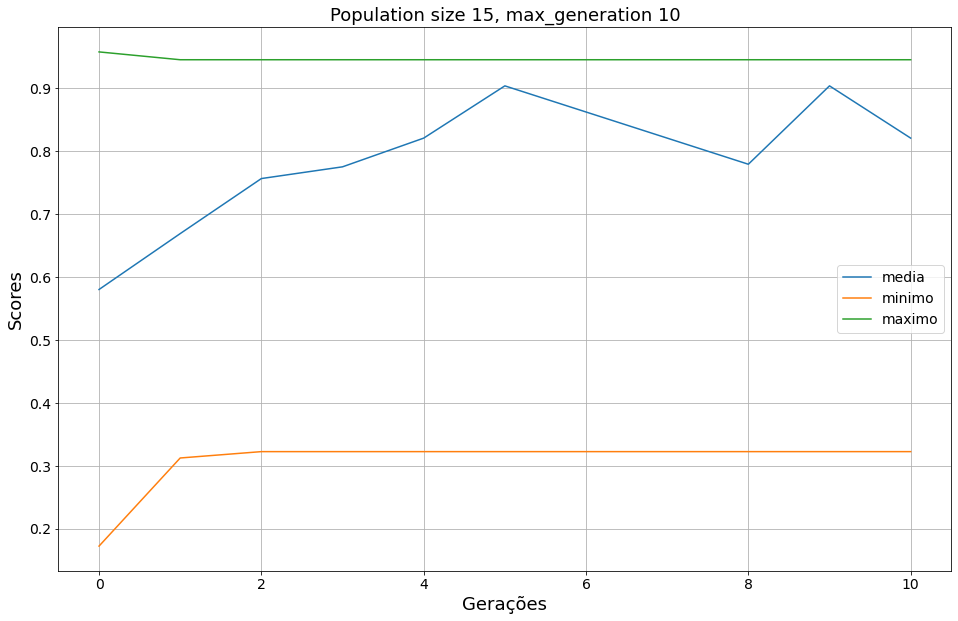


The best layout of neural network is (10, 13), accuracy = (0.9577000000000001,)


In [ ]:
import matplotlib.pyplot as plt

# taking data
y_min = logbook.select("min")
y_max = logbook.select("max")
y_mean = logbook.select("mean")
x_gen = logbook.select("gen")


#plotting
plt.figure(figsize=(16,  10))
plt.plot(x_gen, y_mean, label="media")
plt.plot(x_gen, y_min, label="minimo")
plt.plot(x_gen, y_max, label="maximo")

plt.title(f"Population size {POPULATION_SIZE}, max_generation {MAX_GENERATIONS}", fontsize="18")
plt.grid()
plt.xlabel("Gerações", fontsize="18")
plt.xticks(fontsize="14")
plt.ylabel("Scores", fontsize="18")
plt.yticks(fontsize="14")
plt.legend(loc=5, fontsize="14")
plt.show()

print(f"\nThe best layout of neural network is {get_layers(hof[0])}, accuracy = {toolbox.evaluate(hof[0])}")

In [ ]:
print("Evaluating with the real fitness function")
for i in hof:
  print(get_layers(i), f" score {fitness_real(i, DATA_SPLITTER)}")

print("Result gifted by the book")
print((15, 5, 8), f"socre {fitness_real((15, 5, 8), DATA_SPLITTER)}")

Evaluating with the real fitness function
(10, 13)  score (0.9800000000000001,)
(5, 9)  score (0.9666666666666668,)
(5, 9)  score (0.9666666666666668,)
(5, 9)  score (0.9666666666666668,)
(5, 9)  score (0.9666666666666668,)
Result gifted by the book
(15, 5, 8) socre (0.9266666666666665,)


<h1> Trying to improve the result with elitism

In [ ]:
from deap import tools
from deap import algorithms

def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [ ]:
from deap import base, creator, tools, algorithms
from sklearn.neural_network import MLPClassifier
import numpy as np
import random

# STRUCTURE
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("ChromosomeStruct", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()


# GENE, CHROMOSOME, INDIVIDUAL, POPULATION
CHROMOSOME_LENGTH: int = 8
BOUND_UP: list = [ 5 ] + [ -1 ]*(CHROMOSOME_LENGTH-1)
BOUND_LOW: list = [15] + [ 15 ]*(CHROMOSOME_LENGTH-1)
def gene(a: int, b: int):
  return random.uniform(a, b)
genes_functions = ()
for i in range(CHROMOSOME_LENGTH):
  toolbox.register(f"Gene_{i}", gene, a=BOUND_LOW[i], b=BOUND_UP[i])
  genes_functions += (toolbox.__getattribute__(f"Gene_{i}"),)
toolbox.register("Chromosome", tools.initCycle, creator.ChromosomeStruct, genes_functions, n=1)
toolbox.register("Individual", toolbox.Chromosome)
toolbox.register("PopulationCreator", tools.initRepeat, list, toolbox.Individual)


# GENETIC OPERATORS
def get_layers(solution: toolbox.Individual):
  layers: list = []
  for i in solution:
    j = round(i)
    if j > 0:
      layers.append(j)
    else:
      break
  layers = tuple(layers)
  return layers

def fitness(solution: toolbox.Individual, data_splitter):
  global X, y, RANDOM_SEED
  layers: list = []
  for i in solution:
    j = round(i)
    if j > 0:
      layers.append(j)
    else:
      break
  layers = get_layers(solution)
  count = sum([i for i in layers])
  model: MLPClassifier = MLPClassifier(hidden_layer_sizes=layers, random_state=RANDOM_SEED)
  cv_scores = cross_val_score(model, X, y, cv=data_splitter, n_jobs=-1, scoring="accuracy", error_score="raise")
  return cv_scores.mean() - 0.01*len(layers) - 0.0001*count,

ETA: int = 10
toolbox.register("evaluate", fitness, data_splitter=DATA_SPLITTER)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", cxSimulatedBinaryBounded2, low=BOUND_LOW, up=BOUND_UP, eta=ETA)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=ETA, 
                 indpb=3/CHROMOSOME_LENGTH)



# STORING THE INFORMATION
stats = tools.Statistics(lambda population: population.fitness.values)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("mean", np.mean)
hof = tools.HallOfFame(2)


# CONTROL PANEL
RANDOM_SEED = 40
random.seed(RANDOM_SEED)
POPULATION_SIZE = 15
PROBABILITY_CROSSOVER = 0.9
PROBABILITY_MUTATION = 0.5
MAX_GENERATIONS = 10 # (stopping condition)


# EVOLVING THE SOLUTION
generationCounter = 0
population = toolbox.PopulationCreator(n=POPULATION_SIZE)
result, logbook = eaSimpleWithElitism(population,
                                      toolbox,
                                      cxpb=PROBABILITY_CROSSOVER,
                                      mutpb=PROBABILITY_MUTATION,
                                      ngen=MAX_GENERATIONS,
                                      stats=stats,
                                      halloffame=hof,
                                      verbose=True)

gen	nevals	max   	min    	mean    
0  	15    	0.7669	-0.0872	0.345684
1  	13    	0.7669	0.0824333	0.389564
2  	11    	0.7669	0.264867 	0.401727
3  	11    	0.7669	0.264867 	0.447089
4  	13    	0.7669	0.264867 	0.447069
5  	12    	0.7669	0.322833 	0.496787
6  	13    	0.800433	0.322833 	0.642558
7  	10    	0.800433	0.322833 	0.72016 
8  	12    	0.800433	0.322833 	0.676184
9  	12    	0.800433	0.322833 	0.690549
10 	13    	0.800433	0.322833 	0.7255  


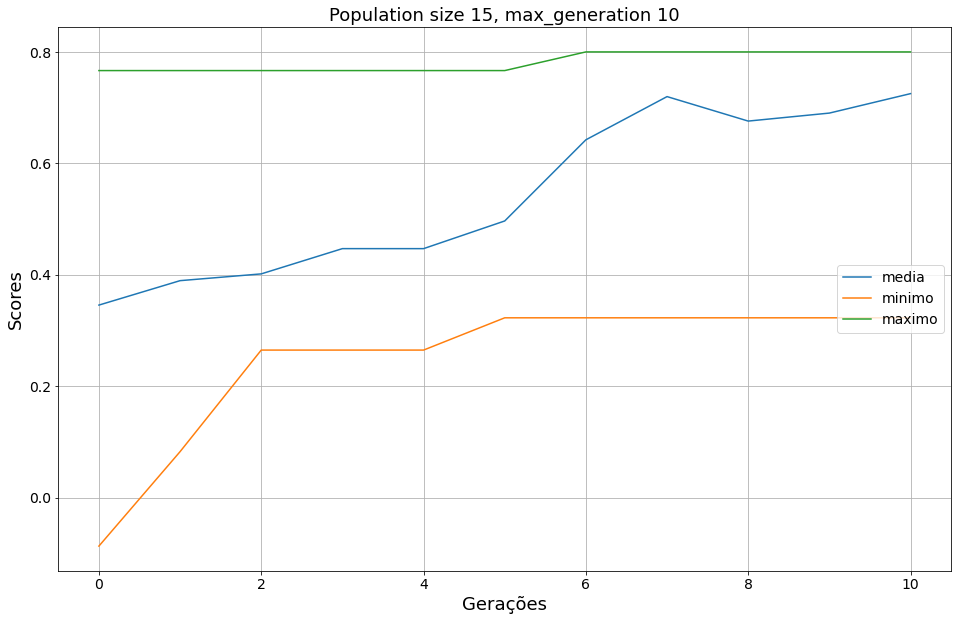


The best layout of neural network is (5, 12, 12), accuracy = (0.8004333333333333,)


In [ ]:
import matplotlib.pyplot as plt

# taking data
y_min = logbook.select("min")
y_max = logbook.select("max")
y_mean = logbook.select("mean")
x_gen = logbook.select("gen")


#plotting
plt.figure(figsize=(16,  10))
plt.plot(x_gen, y_mean, label="media")
plt.plot(x_gen, y_min, label="minimo")
plt.plot(x_gen, y_max, label="maximo")

plt.title(f"Population size {POPULATION_SIZE}, max_generation {MAX_GENERATIONS}", fontsize="18")
plt.grid()
plt.xlabel("Gerações", fontsize="18")
plt.xticks(fontsize="14")
plt.ylabel("Scores", fontsize="18")
plt.yticks(fontsize="14")
plt.legend(loc=5, fontsize="14")
plt.show()

print(f"\nThe best layout of neural network is {get_layers(hof[0])}, accuracy = {toolbox.evaluate(hof[0])}")

In [ ]:
print("Evaluating with the real fitness function")
for i in hof:
  print(get_layers(i), f" score {fitness_real(i, DATA_SPLITTER)}")

print("Result gifted by the book")
print((15, 5, 8), f"socre {fitness_real((15, 5, 8), DATA_SPLITTER)}")

Evaluating with the real fitness function
(5, 12, 12)  score (0.8333333333333334,)
(5, 12, 12)  score (0.8333333333333334,)
Result gifted by the book
(15, 5, 8) socre (0.5266666666666666,)


<h1> Trying to improve the result with Hyperparameters tuning


Our chromosome will be represented by a list of twelve real values, where de 8 firsts will be de dimensions os layers and the last 4 genes will be the hyperparameters 


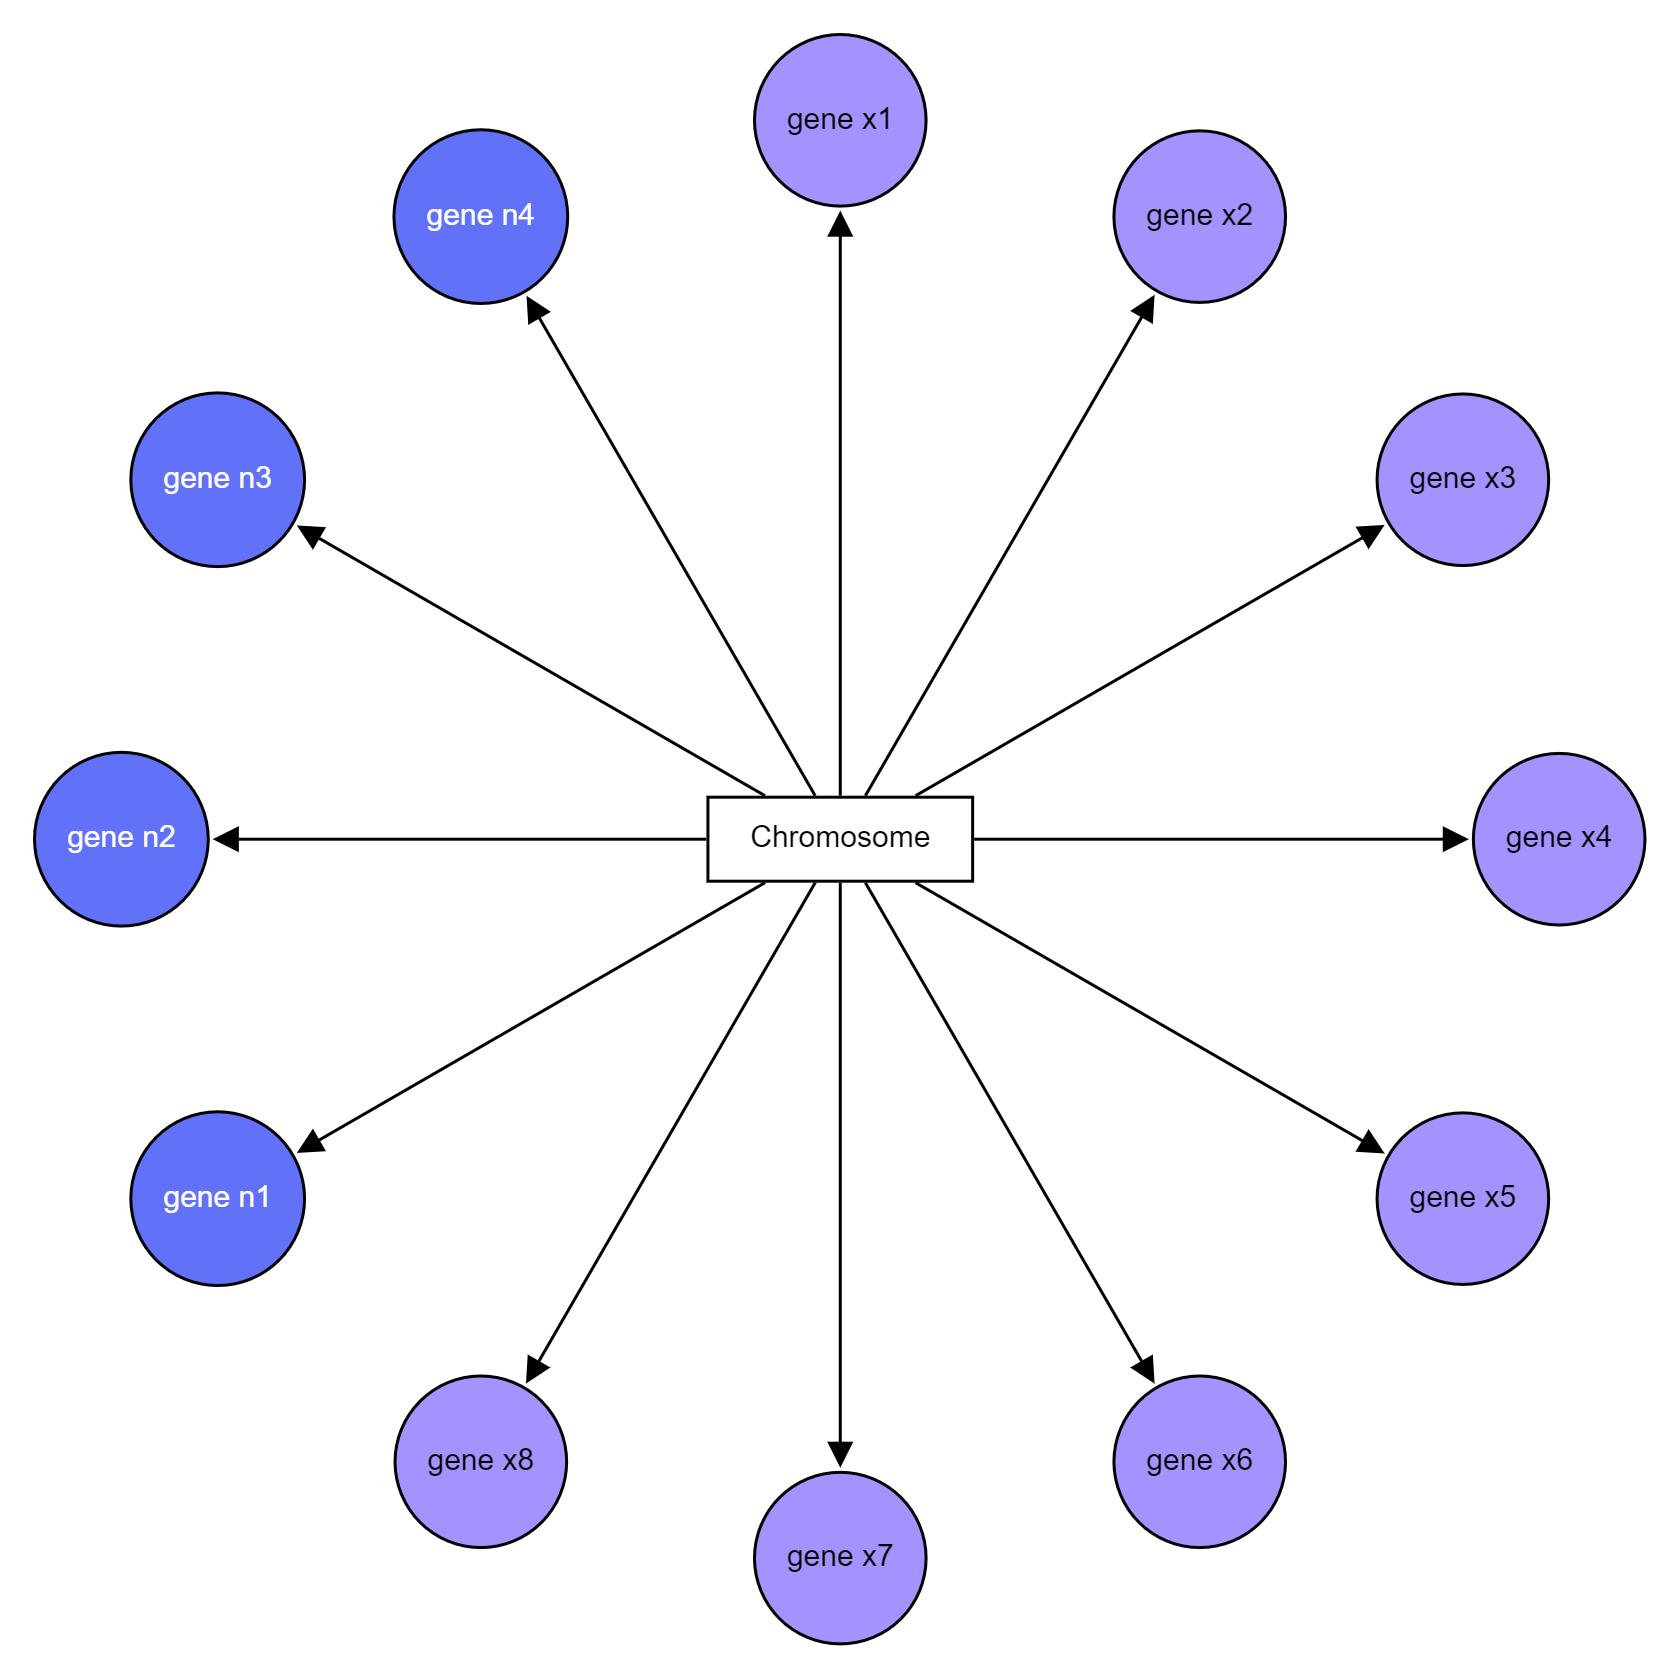

In [ ]:
def fitness_real_2(solution: toolbox.Individual, data_splitter):
  global X, y, RANDOM_SEED
  layers: list = []
  for i in solution:
    j = round(i)
    if j > 0:
      layers.append(j)
    else:
      break
  layers, p = get_layers2(solution)
  count = sum([i for i in layers])
  model: MLPClassifier = MLPClassifier(hidden_layer_sizes=layers, random_state=RANDOM_SEED, 
                                       activation= p[0],
                                       solver= p[1],
                                       alpha= p[2],
                                       learning_rate=p[3])
  cv_scores = cross_val_score(model, X, y, cv=data_splitter, n_jobs=-1, scoring="accuracy")
  return cv_scores.mean(),

In [ ]:
from deap import base, creator, tools, algorithms
from sklearn.neural_network import MLPClassifier
import numpy as np
import random

# STRUCTURE
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("ChromosomeStruct", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()


# GENE, CHROMOSOME, INDIVIDUAL, POPULATION
CHROMOSOME_LENGTH: int = 12
BOUND_UP: list = [ 5 ] + [ -1 ]*(8-1) + [2, 2, 2, 2]
BOUND_LOW: list = [15] + [ 15 ]*(8-1) + [0, 0, 0.001, 0]
def gene(a: int, b: int):
  return random.uniform(a, b)
genes_functions = ()
for i in range(CHROMOSOME_LENGTH):
  toolbox.register(f"Gene_{i}", gene, a=BOUND_LOW[i], b=BOUND_UP[i])
  genes_functions += (toolbox.__getattribute__(f"Gene_{i}"),)
toolbox.register("Chromosome", tools.initCycle, creator.ChromosomeStruct, genes_functions, n=1)
toolbox.register("Individual", toolbox.Chromosome)
toolbox.register("PopulationCreator", tools.initRepeat, list, toolbox.Individual)


# GENETIC OPERATORS
def get_layers2(solution: toolbox.Individual):
  layers: list = []
  for i in solution[0:8]:
    j = round(i)
    if j > 0:
      layers.append(j)
    else:
      break
  layers = tuple(layers)
  p = [['tanh', 'relu', 'logistic'][round(solution[8])], 
       ['sgd', 'adam', 'lbfgs'][round(solution[9])],
       solution[10],
       ['constant', 'invscaling', 'adaptive'][round(solution[11])]]

  return layers, p

def fitness(solution: toolbox.Individual, data_splitter):
  global X, y, RANDOM_SEED
  layers: list = []
  for i in solution:
    j = round(i)
    if j > 0:
      layers.append(j)
    else:
      break
  layers, p = get_layers2(solution)
  count = sum([i for i in layers])
  model: MLPClassifier = MLPClassifier(hidden_layer_sizes=layers, random_state=RANDOM_SEED, 
                                       activation= p[0],
                                       solver= p[1],
                                       alpha= p[2],
                                       learning_rate=p[3])
  cv_scores = cross_val_score(model, X, y, cv=data_splitter, n_jobs=-1, scoring="accuracy")
  return cv_scores.mean() - 0.01*len(layers) - 0.0001*count,

ETA: int = 10
toolbox.register("evaluate", fitness, data_splitter=DATA_SPLITTER)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", cxSimulatedBinaryBounded2, low=BOUND_LOW, up=BOUND_UP, eta=ETA)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=ETA, 
                 indpb=1./CHROMOSOME_LENGTH)



# STORING THE INFORMATION
stats = tools.Statistics(lambda population: population.fitness.values)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("mean", np.mean)
hof = tools.HallOfFame(3)


# CONTROL PANEL
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
POPULATION_SIZE = 20
PROBABILITY_CROSSOVER = 0.8
PROBABILITY_MUTATION = 0.5
MAX_GENERATIONS = 10 # (stopping condition)


# EVOLVING THE SOLUTION
generationCounter = 0
population = toolbox.PopulationCreator(n=POPULATION_SIZE)
result, logbook = eaSimpleWithElitism(population,
                                      toolbox,
                                      cxpb=PROBABILITY_CROSSOVER,
                                      mutpb=PROBABILITY_MUTATION,
                                      ngen=MAX_GENERATIONS,
                                      stats=stats,
                                      halloffame=hof,
                                      verbose=True)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'ChromosomeStruct' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	max   	min    	mean    
0  	20    	0.8687	-0.0872	0.339302
1  	10    	0.922833	-0.0763	0.57195 
2  	14    	0.922833	-0.0022	0.708758
3  	13    	0.9295  	0.384867	0.866223
4  	13    	0.9295  	0.8687  	0.917967
5  	14    	0.9295  	0.916167	0.924127
6  	14    	0.9295  	0.922833	0.9265  
7  	11    	0.9295  	0.922833	0.928167
8  	15    	0.936167	0.922833	0.9295  
9  	13    	0.936167	0.922833	0.9295  
10 	14    	0.936167	0.916167	0.931167


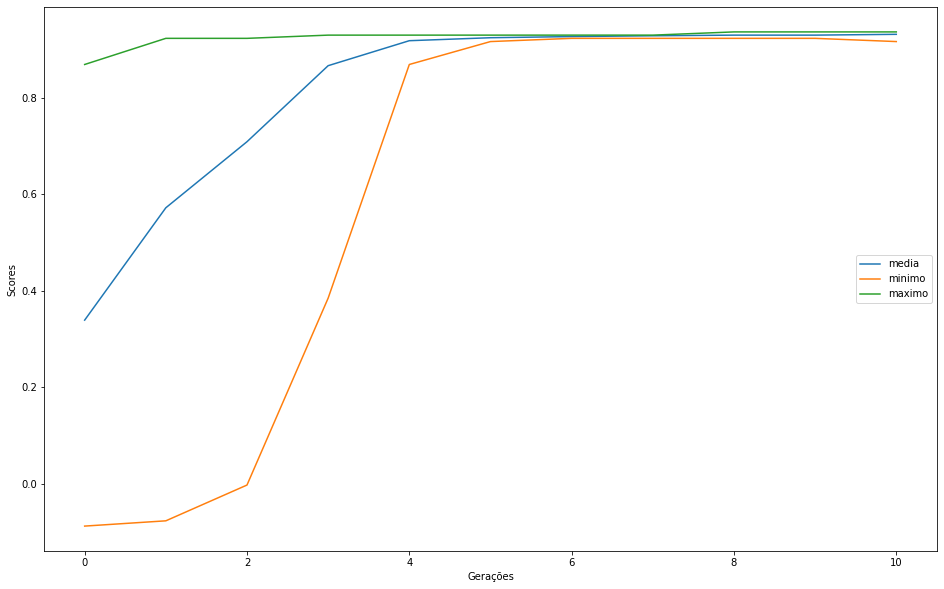


The best layout of neural network is ((5,), ['relu', 'lbfgs', 0.24537657228794288, 'invscaling']), accuracy = (0.9361666666666667,)


In [ ]:
import matplotlib.pyplot as plt

# taking data
y_min = logbook.select("min")
y_max = logbook.select("max")
y_mean = logbook.select("mean")
x_gen = logbook.select("gen")


#plotting
plt.figure(figsize=(16,  10))
plt.plot(x_gen, y_mean, label="media")
plt.plot(x_gen, y_min, label="minimo")
plt.plot(x_gen, y_max, label="maximo")

plt.title(f"Population size {POPULATION_SIZE}, max_generation {MAX_GENERATIONS}", fontsize="18")
plt.grid()
plt.xlabel("Gerações", fontsize="18")
plt.xticks(fontsize="14")
plt.ylabel("Scores", fontsize="18")
plt.yticks(fontsize="14")
plt.legend(loc=5, fontsize="14")
plt.show()

print(f"\nThe best layout of neural network is {get_layers(hof[0])}, accuracy = {toolbox.evaluate(hof[0])}")

In [ ]:
print("Evaluating with the real fitness function")
for i in hof:
  print(get_layers(i), f" score {fitness_real_2(i, DATA_SPLITTER)}")

print("Result gifted by the book")
print((15, 5, 8), f"score {fitness_real((15, 5, 8), DATA_SPLITTER)}")

Evaluating with the real fitness function
(5,)  score (0.9466666666666667,)
(5,)  score (0.9466666666666667,)
(5,)  score (0.9466666666666667,)
Result gifted by the book
(15, 5, 8) score (0.8666666666666666,)
